In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [104]:
data = load_wine()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Class'] = data.target
target = np.unique(data.target)
target_names = np.unique(data.target_names)
targets = dict(zip(target, target_names))
df['Class'] = df['Class'].replace(targets)

In [105]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


In [106]:
x = df.drop(columns="Class")
y = df["Class"]
feature_names = x.columns
labels = y.unique()
X_train, X_test, y_train, y_test = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [107]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-9))

In [108]:
def gini(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

In [109]:
def information_gain(parent_y, left_y, right_y, criterion_fn):
    parent_impurity = criterion_fn(parent_y)
    n = len(parent_y)
    weighted_child = (len(left_y)/n)*criterion_fn(left_y) + (len(right_y)/n)*criterion_fn(right_y)
    return parent_impurity - weighted_child

In [110]:
# decision tree node where the splits and values are stored, values refer to the leaf class index
class DTNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [111]:
class CustomDecisionTree:
    def __init__(self, max_depth=3, min_leaf=5, criterion="entropy"):
        self.max_depth = max_depth # maximum depth for stopping criteria
        self.min_leaf = min_leaf # minimum samples per leaf for stopping criteria
        self.criterion_fn = entropy if criterion == "entropy" else gini # swap between impurity functions
        self.root = None

    def fit(self, X, y):
        # map class labels to integers
        self.labels = np.unique(y)
        self.classes = {label: i for i, label in enumerate(self.labels)}
        y = np.array([self.classes[label] for label in y])
        self.root = self._grow_tree(X.to_numpy(), y, depth=0) # build tree recursively from the root

    # we use this to find the best feature, threshold, and info gain for splits
    def _best_split(self, X, y):
        best_feature = None
        best_thresh = None
        best_gain = -1e9 # look for max gain by starting at the lowest possible value
        n_features = X.shape[1]

        # iterate every combination of features and thresholds to find the best split
        for feature in range(n_features):
            values = np.unique(X[:, feature])
            for t in values:
                # create left and right splits based on threshold
                left = X[:, feature] <= t
                right = ~left

                # check stopping condition for minimum samples per leaf
                if sum(left) < self.min_leaf or sum(right) < self.min_leaf:
                    continue
                
                # track the best split based on information gain
                gain = information_gain(y, y[left], y[right], self.criterion_fn)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresh = t

        return best_feature, best_thresh

    def _grow_tree(self, X, y, depth):
        # check stopping condition for maximum depth or pure leaf (only one class left)
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return DTNode(value=np.argmax(np.bincount(y)))

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return DTNode(value=np.argmax(np.bincount(y)))

        # if we dont find a valid split, create a leaf node
        left = X[:, feature] <= threshold
        right = ~left

        left_child = self._grow_tree(X[left], y[left], depth + 1)
        right_child = self._grow_tree(X[right], y[right], depth + 1)
        return DTNode(feature, threshold, left_child, right_child)

    # if the node is a leaf, return its value, else traverse left or right based on threshold test
    def _classify(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._classify(x, node.left)
        else:
            return self._classify(x, node.right)

    def predict(self, X):
        preds = [self._classify(sample, self.root) for sample in X.to_numpy()]
        inv_classes = {v: k for k, v in self.classes.items()}
        return np.array([inv_classes[p] for p in preds])

In [112]:
dt_custom = CustomDecisionTree(max_depth=3, min_leaf=10, criterion="entropy")
dt_custom.fit(X_train, y_train)
pred_custom = dt_custom.predict(X_test)
acc_custom = accuracy_score(y_test, pred_custom)

print("Custom Tree (Entropy) Accuracy:", acc_custom)
print("Custom Tree (Entropy) Training Accuracy:", accuracy_score(y_train, dt_custom.predict(X_train)))

Custom Tree (Entropy) Accuracy: 0.8703703703703703
Custom Tree (Entropy) Training Accuracy: 0.9193548387096774


In [113]:
dt_custom = CustomDecisionTree(max_depth=3, min_leaf=10, criterion="gini")
dt_custom.fit(X_train, y_train)
pred_custom = dt_custom.predict(X_test)
acc_custom = accuracy_score(y_test, pred_custom)

print("Custom Tree (Gini) Accuracy:", acc_custom)
print("Custom Tree (Gini) Training Accuracy:", accuracy_score(y_train, dt_custom.predict(X_train)))

Custom Tree (Gini) Accuracy: 0.9444444444444444
Custom Tree (Gini) Training Accuracy: 0.9516129032258065


Sklearn Tree (Entropy) Accuracy: 0.8888888888888888
Sklearn Tree (Entropy) Training Accuracy: 0.9193548387096774
Sklearn Tree (Gini) Accuracy: 0.9444444444444444
Sklearn Tree (Gini) Training Accuracy: 0.9516129032258065


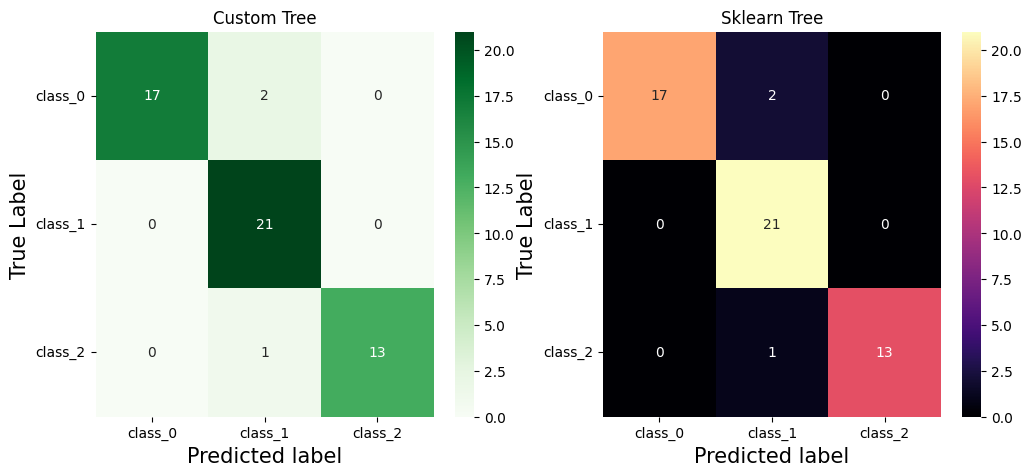

In [114]:
# sklearn's implementation and comparison of performance
dt_sklearn = DecisionTreeClassifier(
    criterion="entropy", max_depth=3, min_samples_leaf=10, random_state=42
)
dt_sklearn.fit(X_train, y_train)
pred_sklearn = dt_sklearn.predict(X_test)
acc_sklearn = accuracy_score(y_test, pred_sklearn)

print("Sklearn Tree (Entropy) Accuracy:", acc_sklearn)
print("Sklearn Tree (Entropy) Training Accuracy:", accuracy_score(y_train, dt_sklearn.predict(X_train)))

dt_sklearn = DecisionTreeClassifier(
    criterion="gini", max_depth=3, min_samples_leaf=10, random_state=42
)
dt_sklearn.fit(X_train, y_train)
pred_sklearn = dt_sklearn.predict(X_test)
acc_sklearn = accuracy_score(y_test, pred_sklearn)

print("Sklearn Tree (Gini) Accuracy:", acc_sklearn)
print("Sklearn Tree (Gini) Training Accuracy:", accuracy_score(y_train, dt_sklearn.predict(X_train)))

# confusion matrices to visualize the implementation performance of both trees
cm_custom = confusion_matrix(y_test, pred_custom)
cm_sklearn = confusion_matrix(y_test, pred_sklearn)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_custom, annot=True, ax=axes[0], fmt="d", cmap="Greens")
axes[0].set_title("Custom Tree")
axes[0].set_xlabel("Predicted label", fontsize=15)
axes[0].set_xticklabels([''] + labels)
axes[0].set_ylabel("True Label", fontsize=15)
axes[0].set_yticklabels(list(labels), rotation=0)

sns.heatmap(cm_sklearn, annot=True, ax=axes[1], fmt="d", cmap="magma")
axes[1].set_title("Sklearn Tree")
axes[1].set_xlabel("Predicted label", fontsize=15)
axes[1].set_xticklabels([''] + labels)
axes[1].set_ylabel("True Label", fontsize=15)
axes[1].set_yticklabels(list(labels), rotation=0)
plt.show()